In [1]:
import pandas as pd
import numpy as np
import datetime

In [2]:
train = pd.read_csv('./output/train.csv')    
test = pd.read_csv('./output/test.csv')    
test2 = pd.read_csv('./output/test2.csv')

x_train = train.drop(columns=['hash','trajectory_id','x_exit','y_exit'])
x_test = test2.drop(columns=['hash','trajectory_id','x_exit','y_exit'])
y_train=pd.DataFrame()
y_train=train[['x_exit','y_exit']]



In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814262 entries, 0 to 814261
Data columns (total 13 columns):
hash             814262 non-null object
trajectory_id    814262 non-null object
time_entry       814262 non-null int64
time_exit        814262 non-null int64
vmax             814262 non-null float64
vmin             814262 non-null float64
vmean            814262 non-null float64
x_entry          814262 non-null float64
y_entry          814262 non-null float64
x_exit           814262 non-null float64
y_exit           814262 non-null float64
x_req            814262 non-null float64
y_req            814262 non-null float64
dtypes: float64(9), int64(2), object(2)
memory usage: 80.8+ MB


In [4]:
test.head()

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit,x_req,y_req
0,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_0,42197,42617,0.0,0.0,0.0,3.773413e+06,-1.909828e+07,3.773111e+06,-1.914508e+07,3.773413e+06,-1.909828e+07
1,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_2,44497,44497,0.0,0.0,0.0,3.773199e+06,-1.914354e+07,3.773199e+06,-1.914354e+07,3.773413e+06,-1.909828e+07
2,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_3,45267,47651,0.0,0.0,0.0,3.763760e+06,-1.921342e+07,3.771757e+06,-1.911092e+07,3.773199e+06,-1.914354e+07
3,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_4,48333,49393,0.0,0.0,0.0,3.773385e+06,-1.911344e+07,3.773131e+06,-1.914465e+07,3.763760e+06,-1.921342e+07
4,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_5,54212,54632,0.0,0.0,0.0,3.773118e+06,-1.914490e+07,NaN,NaN,3.773385e+06,-1.911344e+07


In [5]:
from sklearn.preprocessing import StandardScaler


sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

D:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\J.K. Pawłowski\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [16]:
import lightgbm as lgb

params = {}
params['learning_rate'] = 0.001
params['num_boost_round']=2000
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'l2'
#params['num_leaves'] = 200
params['max_depth'] = 10
#params['verbose']=1



In [17]:
d_train = lgb.Dataset(x_train, label=y_train.x_exit.values)
clf = lgb.train(params, d_train)
#Prediction
predx=clf.predict(x_test)

d_train = lgb.Dataset(x_train, label=y_train.y_exit.values)
clf = lgb.train(params, d_train)
#Prediction
predy=clf.predict(x_test)

D:\Anaconda\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\Anaconda\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [18]:

#pred = pd.DataFrame(data=pred,columns=['x_exit','y_exit'])
pred = pd.DataFrame({'x_exit':predx,'y_exit':predy})

In [19]:
def within_measure(x, y):
    #  3750901.5068 ≤ 𝑥 ≤ 3770901.5068
    #  −19268905.6133 ≤ 𝑦 ≤ −19208905.6133
    if 3750901.5068 <= x and x <= 3770901.5068 and -19268905.6133 <= y and y <= -19208905.6133:
        return 1
    else:
        return 0

X = pred['x_exit'].values 
Y = pred['y_exit'].values

city = [within_measure(x, y) for x,y in zip(X,Y)]

In [20]:
submission= pd.DataFrame()
trajectory_id = test2['trajectory_id']
submission['id']=trajectory_id 
submission['target'] = city
submission.to_csv('./output/submission_lgbm.csv',index=False)    
submission[:20]

,id,target
0,traj_00032f51796fd5437b238e3a9823d13d_31_5,0
1,traj_000479418b5561ab694a2870cc04fd43_25_10,0
2,traj_000506a39775e5bca661ac80e3f466eb_29_5,1
3,traj_0005401ceddaf27a9b7f0d42ef1fbe95_1_4,0
4,traj_00063a4f6c12e1e4de7d876580620667_3_4,0
5,traj_0006535be25bb52dd06983447880c964_5_12,0
6,traj_0006f84bb33ec929d1cda7686f861d0a_31_3,1
7,traj_00093ae562586aed0e053b8431e8ace4_23_10,0
8,traj_000c739e444a70e1804d757a0580caaa_31_3,1
9,traj_000d479078af08618bddc7f09082b8c3_11_6,0


In [21]:
min(city)

0

In [22]:
max(city)

1

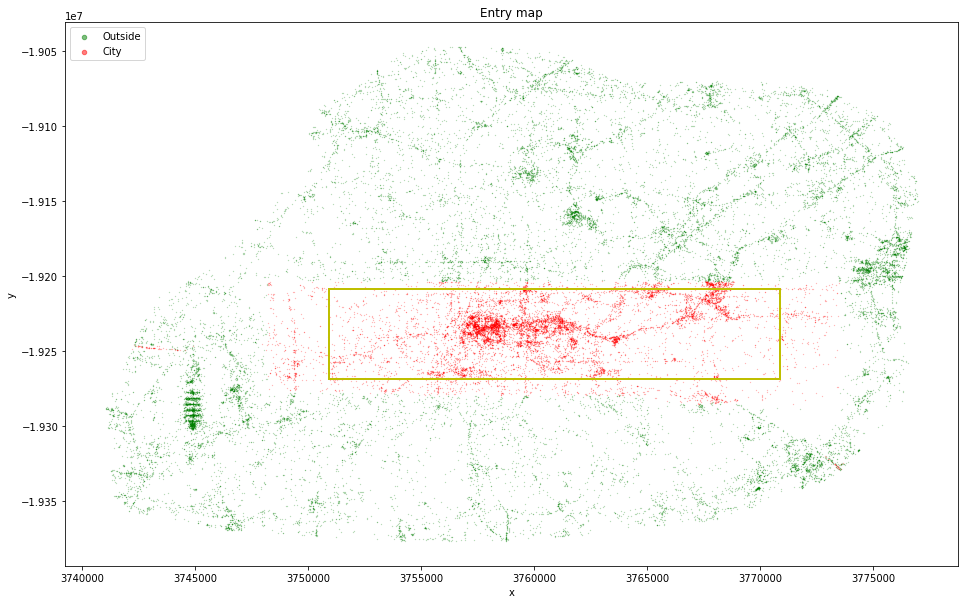

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)


colors = ['g','r']
leg=['Outside','City']
# Plot
for data in [test2[submission.target==0],test2[submission.target==1]]:
    ax.scatter(data.x_entry.values, data.y_entry.values,s=.05, c=colors.pop(0), alpha=0.5,label=leg.pop(0))
    
# Create a Rectangle patch
rect = patches.Rectangle((3750901.5068,-19268905.6133),3770901.5068-3750901.5068,19268905.6133-19208905.6133,linewidth=2,edgecolor='y',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)    

ax.set(xlabel='x', ylabel='y',
       title='Entry map')
ax.legend(loc="upper left", markerscale=20, scatterpoints=1, fontsize=10)
plt.show()

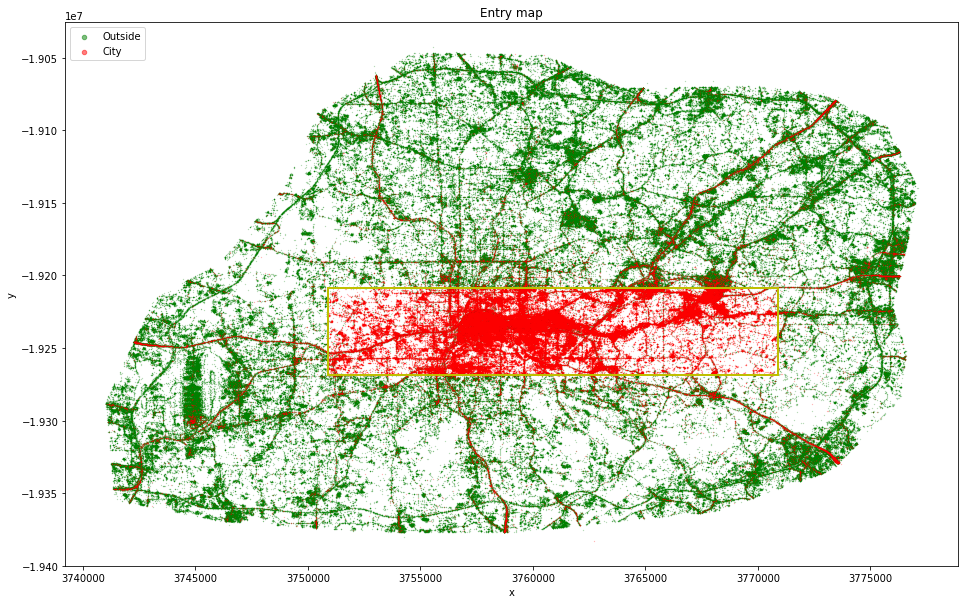

In [24]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)

X=train.x_exit.values
Y=train.y_exit.values

train_city = [within_measure(x, y) for x,y in zip(X,Y)]
train['target']=train_city
colors = ['g','r']
leg=['Outside','City']
# Plot
for data in [train[train.target==0],train[train.target==1]]:
    ax.scatter(data.x_entry.values, data.y_entry.values,s=.05, c=colors.pop(0), alpha=0.5,label=leg.pop(0))
    
# Create a Rectangle patch
rect = patches.Rectangle((3750901.5068,-19268905.6133),3770901.5068-3750901.5068,19268905.6133-19208905.6133,linewidth=2,edgecolor='y',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)    

ax.set(xlabel='x', ylabel='y',
       title='Entry map')
ax.legend(loc="upper left", markerscale=20, scatterpoints=1, fontsize=10)
plt.show()

In [40]:
from sklearn.neighbors import NearestNeighbors

X=train[['x_entry','y_entry']].values


neigh = NearestNeighbors(10, 0.5,algorithm='auto')
neigh.fit(X)  
train['neigh']=neigh.kneighbors(X, return_distance=False)

X=test2[['x_entry','y_entry']]
test2['neigh']=neigh.kneighbors(X, return_distance=False)




ValueError: Length of values does not match length of index